In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import random

from collections import deque
import matplotlib.pyplot as plt

import json

# Word2Vec Implementation
We will implement the Word2Vec model using the CBOW (Continuous Bag of Words) architecture. 

In [2]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords') # for stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mohammed\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mohammed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
file_path = 'small_corpus.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

## Preprocessing: Generating Training Data (Small Corpus)

In [4]:
def extract_unique_words(text):
    
    text = text.lower() 
    words = word_tokenize(text) # tokenization

    words = [word for word in words if word.isalpha()] # remove punctuation, list of just words

    print(f'Number of words: {len(words)}')

    unique_words = sorted(set(words))
    print(f'Number of unique words: {len(unique_words)}')

    return unique_words

In [5]:
unique_words = extract_unique_words(text)

Number of words: 210000
Number of unique words: 20


**Sliding Window Approach**:   
We will use a sliding window approach to generate the training data. The window size is a hyperparameter that we can tune. The window size is the number of words to the left and right of the target word.  

![CBOW](https://nathanrooy.github.io/posts/2018-03-22/word2vec-from-scratch-with-python-and-numpy/text-example.png)

In [6]:
def generate_cbows(text, window_size):

    text = text.lower()
    words = word_tokenize(text)

    words = [word for word in words if word.isalpha()]

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # create CBOW pairs: (context, target) 
    cbows = []
    for i, target_word in enumerate(words):
        context_words = words[max(0, i - window_size):i] + words[i + 1 : i + window_size + 1]
        if len(context_words) == 2 * window_size:
            cbows.append((context_words, target_word))
    
    return cbows

In [7]:
cbows = generate_cbows(text, window_size=3)

for context_words, target_word in cbows[:3]:
    print(f'Context words: {context_words}, Target word: {target_word}')

Context words: ['pet', 'house', 'dog', 'play', 'animal', 'sleep'], Target word: cat
Context words: ['house', 'dog', 'cat', 'animal', 'sleep', 'pet'], Target word: play
Context words: ['dog', 'cat', 'play', 'sleep', 'pet', 'animal'], Target word: animal


In [8]:
len(cbows)

209994

### One-Hot Encoding
We will use one-hot encoding so we can represent the words as vectors and use them as input to the neural network.

In [9]:
def one_hot_encode(word, unique_words):
    encoding = [1 if word == w else 0 for w in unique_words]
    return torch.tensor(encoding, dtype=torch.float32)

In [10]:
# Create one-hot encodings for all unique words
one_hot_encodings = {word: one_hot_encode(word, unique_words) for word in unique_words}
one_hot_encodings['play']

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.])

In [11]:
# Convert CBOW pairs to one-hot encodings (vector pairs)
cbow_vector_paris = [([one_hot_encodings[word] for word in context_words], one_hot_encodings[target_word]) for context_words, target_word in cbows]

In [12]:
cbow_vector_paris[0][0] # context words

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.]),
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1.])]

In [13]:
cbow_vector_paris[0][1] # target word

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [15]:
# Sum the context vectors to a single context vector
cbow_vector_paris = [(torch.sum(torch.stack(context_vectors), dim=0), target_vector) for context_vectors, target_vector in cbow_vector_paris]

We see that there is one input vector which is the sum of the input context words, and one output vector for the center word.

In [16]:
cbow_vector_paris[0]

(tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
         0., 1.]),
 tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

## Converting dataset to PyTorch Dataset 

In [30]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.inputs = [item[0] for item in data]
        self.outputs = [item[1] for item in data]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_sample = self.inputs[idx]
        output_sample = self.outputs[idx]
        return input_sample,output_sample


In [42]:
# Shuffle pairs before training
cbow_vector_paris = random.sample(cbow_vector_paris, len(cbow_vector_paris))

split_index = int(len(cbow_vector_paris)*0.90)

train_dataset = CustomDataset(cbow_vector_paris[:split_index])
test_dataset = CustomDataset(cbow_vector_paris[split_index:])

batch_size = 64

# Create DataLoader for training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Naive Implementation of Word2Vec Model
The model represents a simple two-layer neural network.
- The first layer is learnable weights initialized randomly  ```W1```: projects the input tensor into a lower-dimensional space **(word embeddings)**. 
- The second layer is learnable weights initialized randomly ```W2```: projects the word embeddings back into the vocabulary space.
- The forward pass of the module performs matrix multiplications between the input tensor and the learnable parameters.

In [43]:
class NaiveWord2Vec(nn.Module):

    def __init__(self, VOCAB_SIZE, VECTOR_DIM) -> None:
        super().__init__()

        self.vocav_size = VOCAB_SIZE
        self.vecotr_dim = VECTOR_DIM
        # Learnable parameters initialized with random values
        self.W1 = nn.Parameter(data=torch.randn(self.vocav_size, self.vecotr_dim, requires_grad=True))
        self.W2 = nn.Parameter(data=torch.randn(self.vecotr_dim, self.vocav_size, requires_grad=True))

    def forward(self, X) -> torch.tensor:
        X = X @ self.W1
        X = X @ self.W2

        return X


In [44]:
VOCAB_SIZE = len(unique_words)
VECTOR_DIM = 2

## Training the model

In [54]:
model = NaiveWord2Vec(VOCAB_SIZE, VECTOR_DIM)
print(model)

NaiveWord2Vec()


In [56]:
def train_model(model, train_dataloader, validation_dataloader, epochs, learning_rate, verbose=False):

    # Create the loss function
    loss_fn = nn.CrossEntropyLoss()
    # Create the optimizer object
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    # Log the loss values
    train_set_loss_log = []
    validation_set_loss_log = []

    for epoch in range(epochs):
        if verbose: print("Epoch: ", epoch)
        # Training mode on
        model.train()
        total_train_loss = 0.0
        num_train_batches = 0

        for inputs_batch, outputs_batch in train_dataloader:

            y_train_logits = model(inputs_batch)
            train_loss = loss_fn(y_train_logits, outputs_batch)
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            total_train_loss += train_loss.item()
            num_train_batches += 1            

        # Calculate average training loss for the epoch
        average_train_loss = total_train_loss / num_train_batches
        train_set_loss_log.append(average_train_loss)
        
        # Eval mode on
        model.eval()            
        total_validation_loss = 0.0
        num_validation_batches = 0

        with torch.inference_mode():
            for inputs_batch, outputs_batch in validation_dataloader:
                # Evaluate the validation loss
                y_val_logits = model(inputs_batch)
                validation_loss = loss_fn(y_val_logits, outputs_batch)

                total_validation_loss += validation_loss.item()
                num_validation_batches += 1
        
        # Calculate average validation loss for the epoch
        average_validation_loss = total_validation_loss / num_validation_batches
        validation_set_loss_log.append(average_validation_loss) 

        if verbose: print("Train Loss: ", average_train_loss, "|||", "Validation Loss: ", average_validation_loss)
        

    return model, train_set_loss_log, validation_set_loss_log

In [57]:
model, train_set_loss_log, validation_set_loss_log = train_model(model, train_dataloader, validation_dataloader, 
                                                                 epochs=3, learning_rate=0.01, verbose=True)

Epoch:  0
Train Loss:  2.003845022107268 ||| Validation Loss:  1.861006408476902
Epoch:  1
Train Loss:  1.8565948856143266 ||| Validation Loss:  1.860681776580115
Epoch:  2
Train Loss:  1.8539896212725036 ||| Validation Loss:  1.8592312495396854


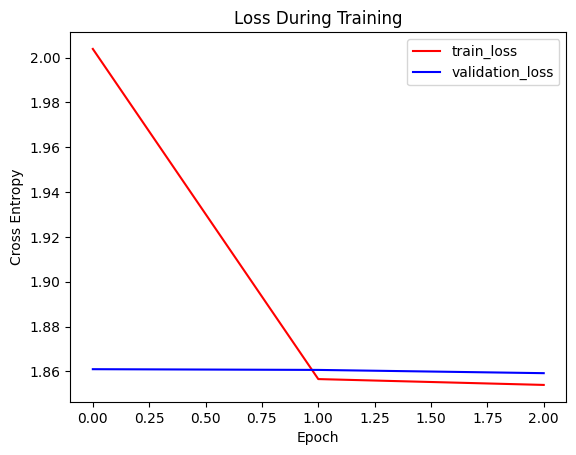

In [58]:
plt.plot(train_set_loss_log, color='red', label='train_loss')
plt.plot(validation_set_loss_log, color='blue', label='validation_loss')

plt.title("Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
plt.legend()
plt.show()

In [59]:
# Word Vectors
params = list(model.parameters())
word_vectors = params[0].detach()

In [60]:
# Create a dictionary with the same order mapping
word_dict = {word: vector for word, vector in zip(unique_words, word_vectors)}

In [61]:
def cosine_similarity(v1, v2):
    return (v1 @ v2) / (torch.norm(v1) * torch.norm(v2))

def most_similar(word, word_dict, top_k=5):
    if word not in word_dict:
        raise ValueError(f"{word} not found in the word dictionary.")

    query_vector = word_dict[word]

    # Calculate cosine similarity with all other words in the dictionary
    similarities = {}
    for other_word, other_vector in word_dict.items():
        if other_word != word:
            similarity = cosine_similarity(query_vector, other_vector)
            similarities[other_word] = similarity

    # Sort the words by similarity in descending order
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Get the top-k most similar words
    top_similar_words = sorted_similarities[:top_k]

    return top_similar_words

In [62]:
word_dict

{'animal': tensor([-0.3216,  0.5989]),
 'boy': tensor([-1.1329, -0.9479]),
 'castle': tensor([0.2576, 0.1293]),
 'cat': tensor([-0.3319,  0.6218]),
 'country': tensor([ 0.1386, -0.1768]),
 'crown': tensor([ 2.3884, -2.0013]),
 'dog': tensor([-1.7478,  2.9096]),
 'empire': tensor([0.2867, 0.0163]),
 'family': tensor([-0.6358, -0.4170]),
 'father': tensor([-1.3877, -1.1143]),
 'girl': tensor([-0.6624, -0.4719]),
 'house': tensor([1.1165, 0.0342]),
 'king': tensor([3.5899, 1.5832]),
 'marriage': tensor([-0.8822, -0.6472]),
 'mother': tensor([-0.7549, -0.6359]),
 'pet': tensor([-0.3940,  0.6312]),
 'play': tensor([-0.3549,  0.6791]),
 'queen': tensor([ 0.2568, -0.1286]),
 'rule': tensor([ 0.0908, -0.1196]),
 'sleep': tensor([-0.3988,  0.6568])}

In [63]:
word_dict['dog']

tensor([-1.7478,  2.9096])

In [64]:
most_similar('dog', word_dict)

[('sleep', tensor(1.0000)),
 ('pet', tensor(0.9999)),
 ('animal', tensor(0.9988)),
 ('cat', tensor(0.9987)),
 ('play', tensor(0.9982))]

In [65]:
most_similar('queen', word_dict)

[('crown', tensor(0.9729)),
 ('country', tensor(0.9040)),
 ('rule', tensor(0.8974)),
 ('house', tensor(0.8800)),
 ('empire', tensor(0.8673))]

In [67]:
cosine_similarity(word_dict['father'], word_dict['mother'])

tensor(0.9997)

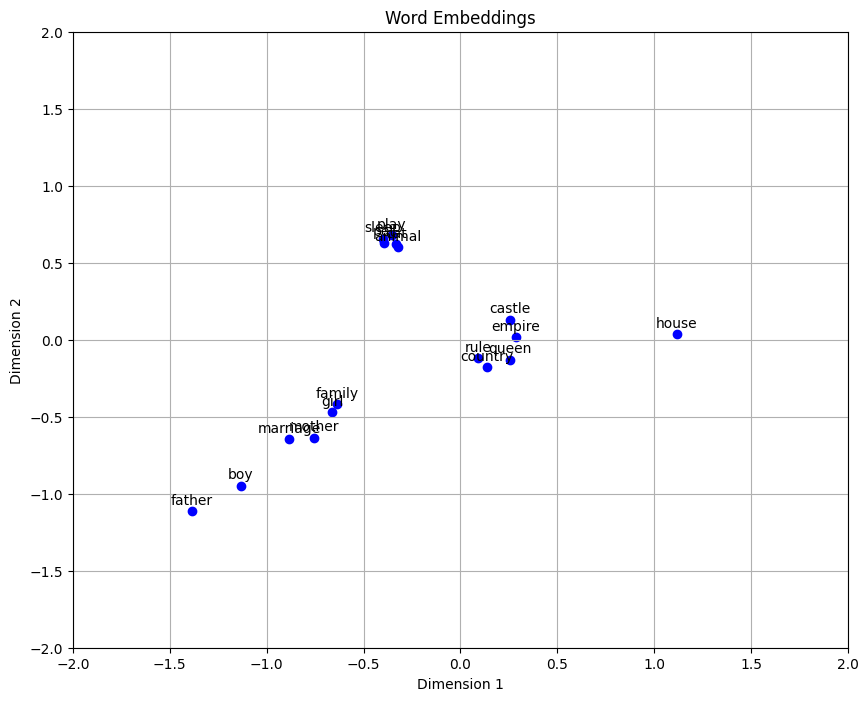

In [66]:
x_coords, y_coords = zip(*[word_dict[word].numpy() for word in list(word_dict.keys())])

plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, marker='o', color='blue')

for i, word in enumerate(list(word_dict.keys())):
    plt.annotate(word, (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()